In [29]:
import pandas as pd
import numpy as np
import sqlalchemy

In [30]:
import pandas as pd
import sqlite3

# Define the SQLite database file path
sqlite_db_path = '../DB/NEWDB/zomato_db.sqlite'

# Define the table name for the staging data
staging_table_name = 'staging_data'

# Connect to the SQLite database and retrieve the staging data
with sqlite3.connect(sqlite_db_path) as conn:
    # Query the staging data
    query = f"SELECT * FROM {staging_table_name}"
    staging_df = pd.read_sql(query, conn)

# Display the first 5 rows of the DataFrame
staging_df.head(5)


,index,NAME,PRICE,CUSINE_CATEGORY,CITY,REGION,CUSINETYPE,TIMING,RATING_TYPE,RATING,VOTES
0,0,The Salt Cafe Kitchen & Bar,1000,"North Indian,Continental,Italian",Agra,Tajganj,Casual Dining,1130am to 1130pm(Mon-Sun),Excellent,4.8,273
1,1,Bhagat Halwai,300,"Desserts,Bakery,Fast Food,South Indian",Agra,Civil Lines,Quick Bites,730am to 11pm(Mon-Sun),Very Good,4.3,554
2,2,Bikanervala,700,"North Indian,South Indian,Mithai,Street Food,D...",Agra,Khandari,Quick Bites,8am to 11pm(Mon-Sun),Very Good,4.4,645
3,3,Mama Chicken Mama Franky House,600,"North Indian,Mughlai,Rolls,Chinese,Fast Food,S...",Agra,Agra Cantt,Quick Bites,"1230pm to 12midnight(Mon,Wed,Thu,Fri,Sat...",Very Good,4.3,894
4,4,Honeydew Restaurant,500,"North Indian,Fast Food,Chinese,South Indian",Agra,Dayal Bagh,Quick Bites,"11am to 1035pm(Mon,Tue,Wed,Fri,Sat),11am to ...",Very Good,4.1,489


In [31]:
staging_df.shape

(211246, 11)

In [32]:
staging_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211246 entries, 0 to 211245
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   index            211246 non-null  int64  
 1   NAME             211246 non-null  object 
 2   PRICE            211246 non-null  int64  
 3   CUSINE_CATEGORY  211116 non-null  object 
 4   CITY             211246 non-null  object 
 5   REGION           211246 non-null  object 
 6   CUSINETYPE       211246 non-null  object 
 7   TIMING           209964 non-null  object 
 8   RATING_TYPE      190170 non-null  object 
 9   RATING           152836 non-null  float64
 10  VOTES            211246 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 17.7+ MB


In [33]:
staging_df.isna().sum()

index                  0
NAME                   0
PRICE                  0
CUSINE_CATEGORY      130
CITY                   0
REGION                 0
CUSINETYPE             0
TIMING              1282
RATING_TYPE        21076
RATING             58410
VOTES                  0
dtype: int64

In [34]:
staging_df.info()  # Check data types and missing values
staging_df.describe()  # Summary statistics for numerical columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211246 entries, 0 to 211245
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   index            211246 non-null  int64  
 1   NAME             211246 non-null  object 
 2   PRICE            211246 non-null  int64  
 3   CUSINE_CATEGORY  211116 non-null  object 
 4   CITY             211246 non-null  object 
 5   REGION           211246 non-null  object 
 6   CUSINETYPE       211246 non-null  object 
 7   TIMING           209964 non-null  object 
 8   RATING_TYPE      190170 non-null  object 
 9   RATING           152836 non-null  float64
 10  VOTES            211246 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 17.7+ MB


,index,PRICE,RATING
count,211246.000000,211246.000000,152836.000000
mean,52811.000000,416.954830,3.481146
std,30490.805909,271.263342,0.408857
min,0.000000,0.000000,1.800000
25%,26405.250000,250.000000,3.200000
50%,52811.000000,350.000000,3.500000
75%,79216.750000,500.000000,3.800000
max,105622.000000,6000.000000,4.900000


In [35]:
staging_df.drop_duplicates(inplace=True)


Distribution of Ratings

<Axes: >

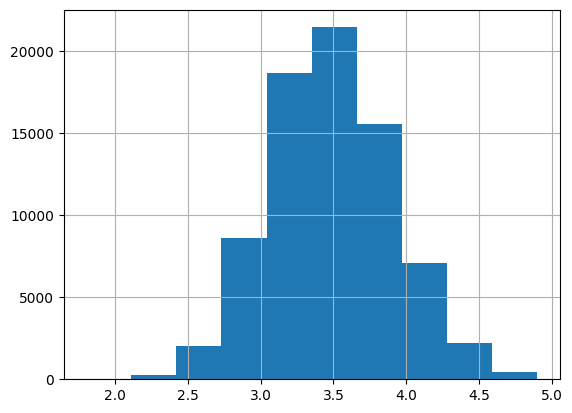

In [36]:
staging_df['RATING'].hist(bins=10)


checking the correlation between the  Rating type and rating 

In [37]:
from sklearn.preprocessing import LabelEncoder

#Label encode the 'RATING_TYPE' column
label_encoder = LabelEncoder()
staging_df['RATING_TYPE_ENCODED'] = label_encoder.fit_transform(staging_df['RATING_TYPE'])

# Step 2: Calculate the correlation between 'RATING' and 'RATING_TYPE_ENCODED'
correlation = staging_df[['RATING', 'RATING_TYPE_ENCODED']].corr()

# Display the correlation matrix
print(correlation)



                       RATING  RATING_TYPE_ENCODED
RATING               1.000000             0.804348
RATING_TYPE_ENCODED  0.804348             1.000000


Finding the missing rows distribution

In [38]:

missing_both = staging_df['RATING'].isnull() & staging_df['RATING_TYPE'].isnull()

missing_both_count = missing_both.sum()


missing_rating_count = staging_df['RATING'].isnull().sum()
missing_rating_type_count = staging_df['RATING_TYPE'].isnull().sum()


print(f"Number of rows where both 'RATING' and 'RATING_TYPE' are missing: {missing_both_count}")
print(f"Number of rows where 'RATING' is missing: {missing_rating_count}")
print(f"Number of rows where 'RATING_TYPE' is missing: {missing_rating_type_count}")


Number of rows where both 'RATING' and 'RATING_TYPE' are missing: 10538
Number of rows where 'RATING' is missing: 29205
Number of rows where 'RATING_TYPE' is missing: 10538


The correlation matrix is good as the value is .8    so we can map the values each other  using linear regression

In [39]:
from sklearn.linear_model import LinearRegression

import numpy as np

# Step 1: Label encode 'RATING_TYPE'
label_encoder = LabelEncoder()
staging_df['RATING_TYPE_ENCODED'] = label_encoder.fit_transform(staging_df['RATING_TYPE'].astype(str))

# Step 2: Identify missing values
missing_rating = staging_df['RATING'].isnull()
missing_rating_type = staging_df['RATING_TYPE'].isnull()


both_missing = missing_rating & missing_rating_type


X = staging_df[['RATING_TYPE_ENCODED']][~missing_rating & ~missing_rating_type] 
y = staging_df['RATING'][~missing_rating & ~missing_rating_type]  

model = LinearRegression()
model.fit(X, y)


staging_df.loc[missing_rating & ~missing_rating_type, 'RATING'] = model.predict(staging_df[['RATING_TYPE_ENCODED']][missing_rating & ~missing_rating_type])




rating_type_mode = staging_df.groupby('RATING')['RATING_TYPE'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan)

staging_df.loc[missing_rating_type & ~missing_rating, 'RATING_TYPE'] = staging_df.loc[missing_rating_type & ~missing_rating, 'RATING'].map(rating_type_mode)


print(staging_df.isnull().sum())


index                      0
NAME                       0
PRICE                      0
CUSINE_CATEGORY           65
CITY                       0
REGION                     0
CUSINETYPE                 0
TIMING                   641
RATING_TYPE            10538
RATING                 10538
VOTES                      0
RATING_TYPE_ENCODED        0
dtype: int64


1. Which locality lists the maximum number of hotels?

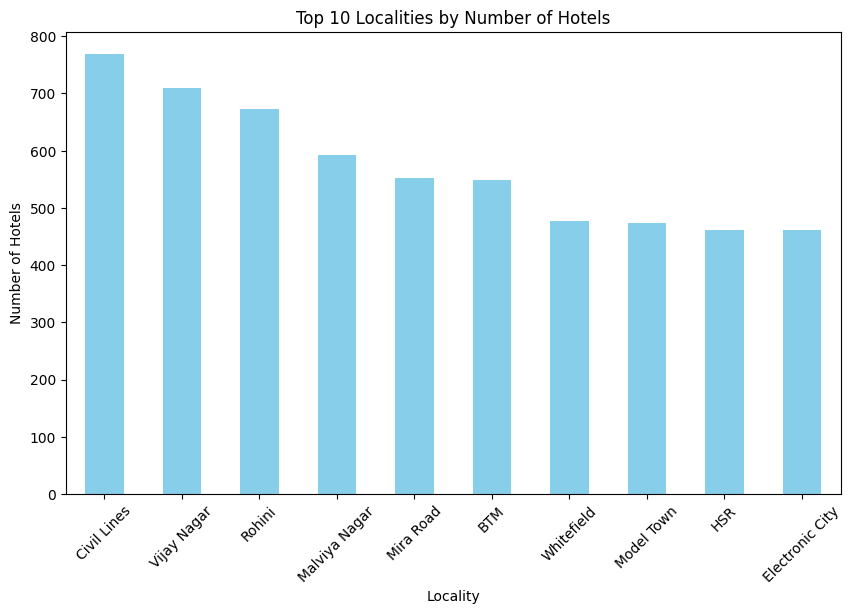

In [40]:
import matplotlib.pyplot as plt

# Group by 'REGION' (locality) and count the number of hotels
region_counts = staging_df['REGION'].value_counts()

# Plot the results
plt.figure(figsize=(10, 6))
region_counts.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Localities by Number of Hotels')
plt.xlabel('Locality')
plt.ylabel('Number of Hotels')
plt.xticks(rotation=45)
plt.show()


2.What cuisine is served in the highest-rated hotels in the country?

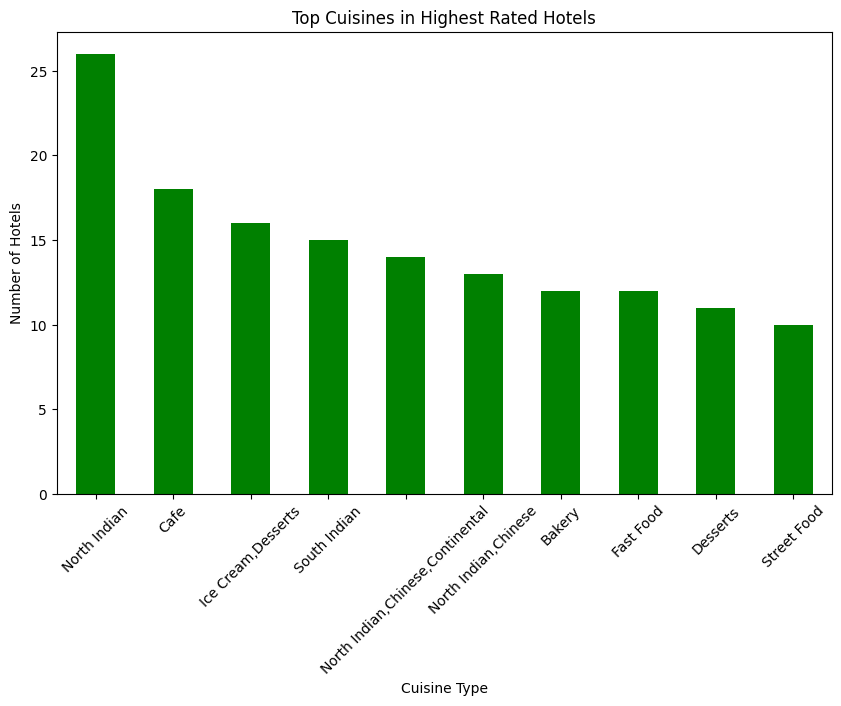

In [41]:
# Filtering the hotels with a high rating (e.g., above 4.5)
high_rated_hotels = staging_df[staging_df['RATING'] >= 4.5]

cuisine_counts = high_rated_hotels['CUSINE_CATEGORY'].value_counts()

plt.figure(figsize=(10, 6))
cuisine_counts.head(10).plot(kind='bar', color='green')
plt.title('Top Cuisines in Highest Rated Hotels')
plt.xlabel('Cuisine Type')
plt.ylabel('Number of Hotels')
plt.xticks(rotation=45)
plt.show()


3. Is there any relation between the cost of dining and the hotel rating?

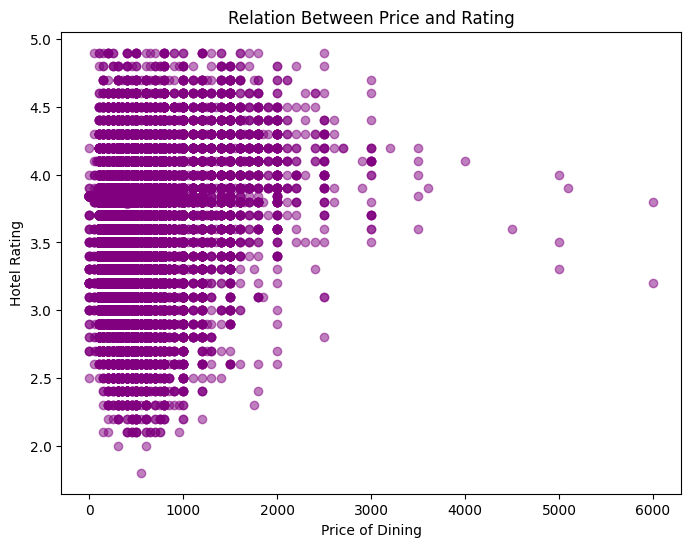

In [42]:
# Scatter plot to show the relationship between 'PRICE' and 'RATING'
plt.figure(figsize=(8, 6))
plt.scatter(staging_df['PRICE'], staging_df['RATING'], color='purple', alpha=0.5)
plt.title('Relation Between Price and Rating')
plt.xlabel('Price of Dining')
plt.ylabel('Hotel Rating')
plt.show()


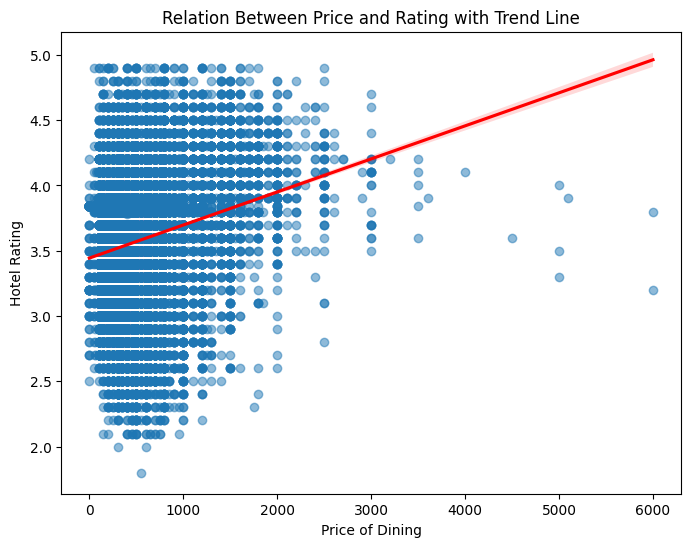

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with trend line (regression line)
plt.figure(figsize=(8, 6))
sns.regplot(x='PRICE', y='RATING', data=staging_df, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
plt.title('Relation Between Price and Rating with Trend Line')
plt.xlabel('Price of Dining')
plt.ylabel('Hotel Rating')
plt.show()


6. Which cuisine dominates Indian taste buds and is there any relation to where the hotel is located?

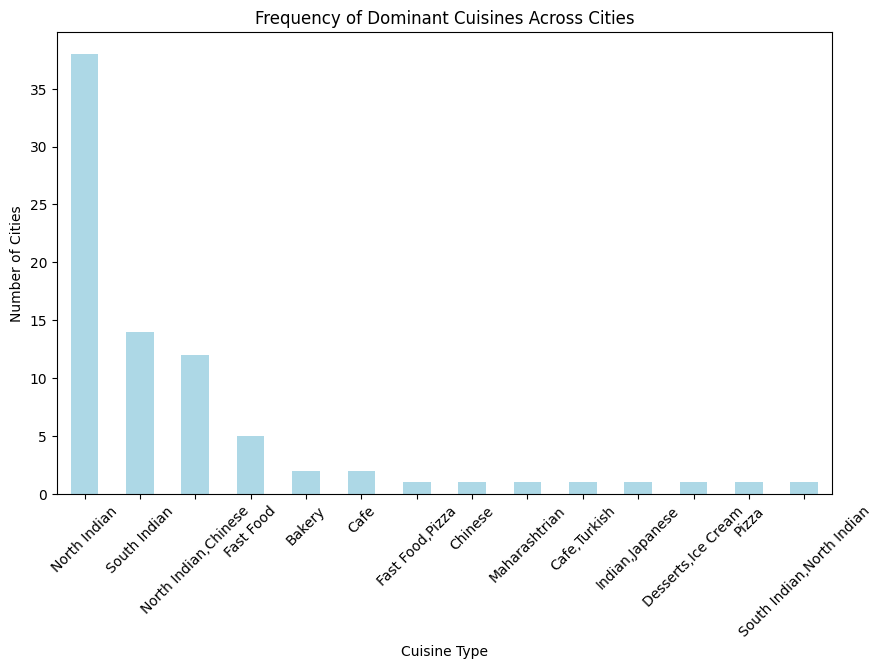

In [44]:
# Count the frequency of each cuisine being the dominant one across cities
dominant_cuisine_counts = dominant_cuisine_by_city.value_counts()

# Plot the frequency of dominant cuisines
plt.figure(figsize=(10, 6))
dominant_cuisine_counts.plot(kind='bar', color='lightblue')
plt.title('Frequency of Dominant Cuisines Across Cities')
plt.xlabel('Cuisine Type')
plt.ylabel('Number of Cities')
plt.xticks(rotation=45)
plt.show()
